In [1]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

# Python native libs
import os
import enum
from collections import namedtuple
import argparse
import numbers
import math


# Deep learning related imports
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
import clip
import open_clip

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt  # visualizations
from PIL import Image

import utils.constants as constants
import utils.utils as utils
import deepdream
import importlib

importlib.reload(deepdream)
importlib.reload(utils)
importlib.reload(constants)

from utils.constants import *
from utils.utils import *
import utils.utils as utils

from deepdream import *

import importlib
importlib.reload(utils)
importlib.reload(constants)

from utils.constants import *
from utils.utils import *
import utils.utils as utils

from collections import defaultdict

In [30]:
pre = open_clip.list_pretrained_tags_by_model("convnext_xxlarge")

for x in pre:
    print("CLIP_"+x.upper())

CLIP_LAION2B_S34B_B82K_AUGREG
CLIP_LAION2B_S34B_B82K_AUGREG_REWIND
CLIP_LAION2B_S34B_B82K_AUGREG_SOUP


In [10]:
model = open_clip.create_model(
                "convnext_xxlarge", 
                pretrained='laion2b_s34b_b82k_augreg_soup', 
                require_pretrained=True
            ).visual.eval()

In [21]:
len(model.trunk.stages)

4

In [12]:
model._modules.keys()


odict_keys(['trunk', 'head'])

In [28]:
import inspect
print(inspect.getsource(model.trunk.stages.forward))
print("====")
print(inspect.getsource(model.trunk.forward_head))

    def forward(self, input):
        for module in self:
            input = module(input)
        return input

====
    def forward_head(self, x, pre_logits: bool = False):
        return self.head(x, pre_logits=True) if pre_logits else self.head(x)



In [24]:
print(inspect.getsource(model.forward))
print("===")
print(inspect.getsource(model.trunk.forward))


    def forward(self, x):
        x = self.trunk(x)
        x = self.head(x)
        return x

===
    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x



In [27]:
model.trunk.stem

Sequential(
  (0): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
  (1): LayerNorm2d((384,), eps=1e-05, elementwise_affine=True)
)

In [17]:
import random

def gen_config(model_name, pretrained_weights, layer_name):

    img_dim = FixedImageResolutions.get(model_name)

    config = {
        'input': 'photo_jellyfish.jpeg',
        'img_dimensions': img_dim,
        'layers_to_use': [layer_name],
        'text_prompt': "Monkeys Moondancing",
        'model_name': model_name,
        'pretrained_weights': pretrained_weights,
        'pyramid_size': 4,
        'pyramid_ratio': 1.6,
        'num_gradient_ascent_iterations': 30,
        'lr': 0.09,
        'should_display': False,
        'spatial_shift_size': 16,
        'smoothing_coefficient': 0.5,
        'use_noise': False,
    }
    config['dump_dir'] = os.path.join(OUT_IMAGES_PATH, f'{config["model_name"]}_{config["pretrained_weights"]}')
    config['input'] = os.path.basename(config['input']) 
    return config

ms = [pw.name for pw in SupportedModels]

layers_per_model = {}
layers_per_model["VGG16"] = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
layers_per_model["VGG16_EXPERIMENTAL"] = ['relu3_3', 'relu4_1', 'relu4_2', 'relu4_3', 'relu5_1', 'relu5_2', 'relu5_3', 'mp5']
layers_per_model["GOOGLENET"] = ['inception3b', 'inception4c', 'inception4d', 'inception4e']
layers_per_model["RESNET50"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["ALEXNET"] = ['relu1', 'relu2', 'relu3', 'relu4', 'relu5']
layers_per_model["RN50"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["RN101"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["RN152"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["CONVNEXT_BASE"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["CONVNEXT_XXLARGE"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["VIT_B_16"] = ['layer1', 'layer4', 'layer7', 'layer11']
layers_per_model["VIT_B_32"] = ['layer1', 'layer4', 'layer7', 'layer11']
layers_per_model["VIT_L_14"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']
layers_per_model["VIT_L_16"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']
layers_per_model["VIT_L_32"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']
layers_per_model["VIT_L_14_336"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']

for m in ms:
    if m.startswith("CLIP") or m.startswith("OPENCLIP"):
        layers_per_model[m] = ["logits_per_image"]


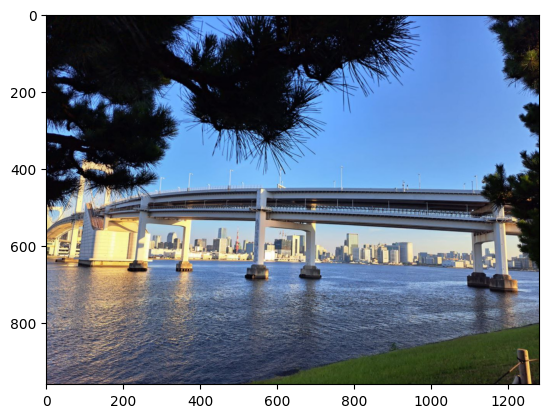

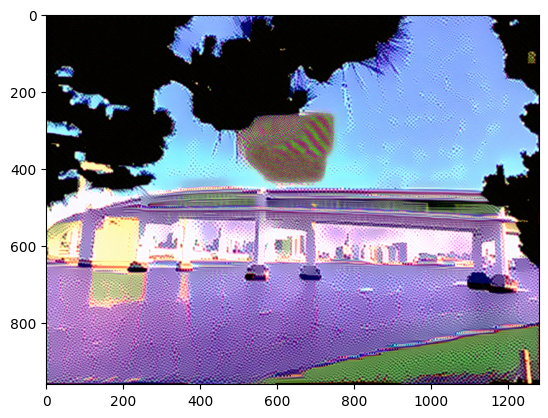

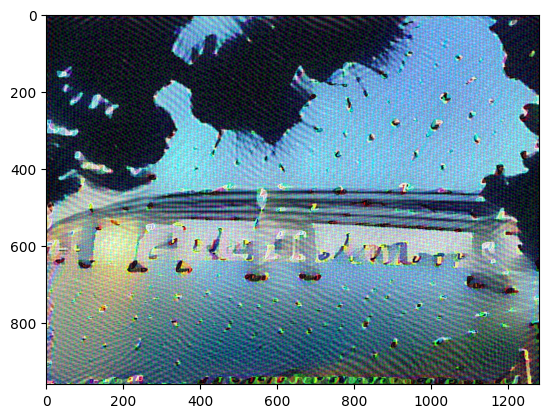

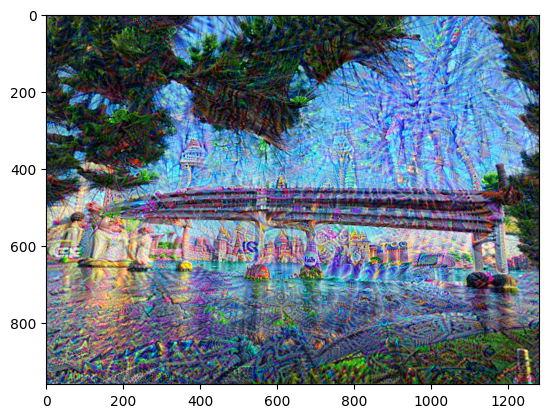

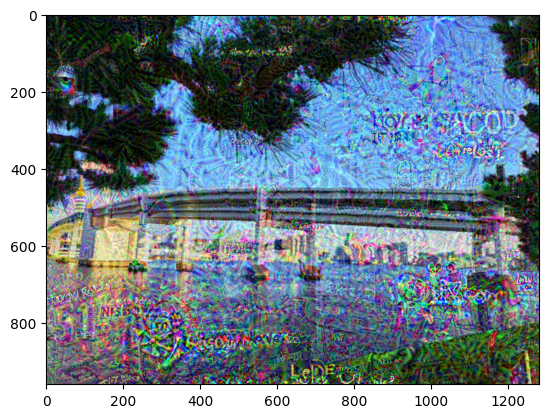

In [15]:
dream_imgs = []
for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
    config = gen_config("CONVNEXT_XXLARGE", "CLIP_LAION2B_S34B_B82K_AUGREG_SOUP", layer_name)
    dream_imgs.append(deep_dream_static_image(config, None))

input_img_name = 'photo_rainbow_bridge.jpeg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = None)

plt.imshow(img)
plt.show()
for img in dream_imgs:
    plt.imshow(img)
    plt.show()

In [18]:
input_img_name = 'photo_jellyfish.jpeg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = None)

img.shape

(1197, 1197, 3)

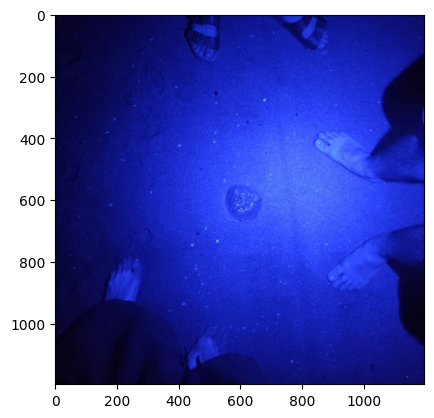

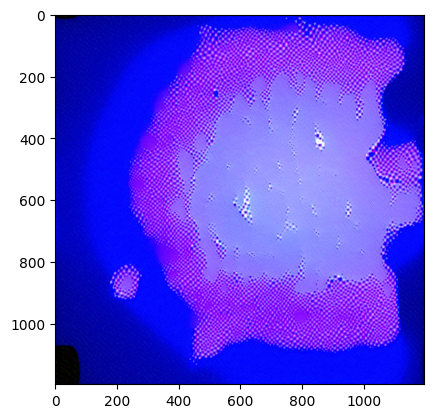

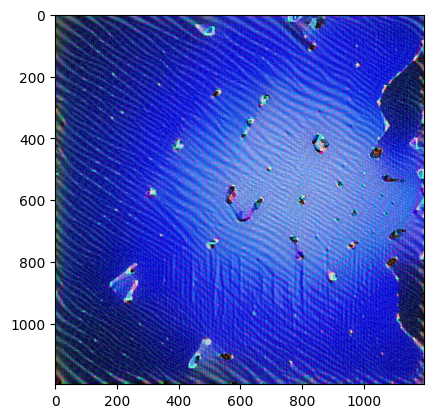

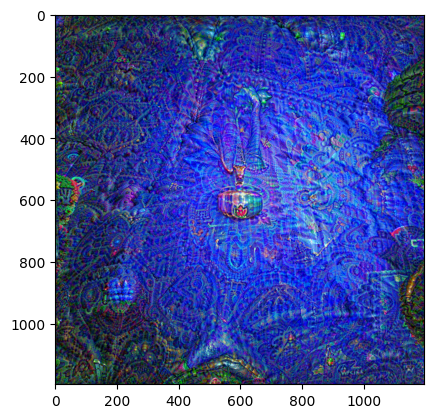

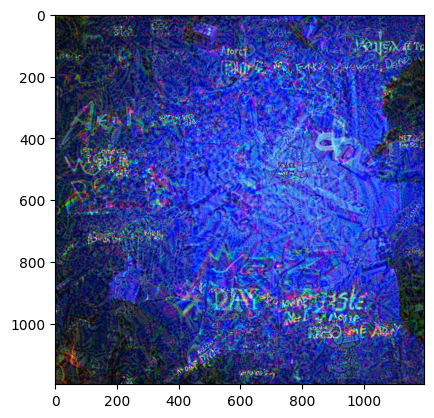

In [19]:
dream_imgs = []
for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
    config = gen_config("CONVNEXT_XXLARGE", "CLIP_LAION2B_S34B_B82K_AUGREG_SOUP", layer_name)
    dream_imgs.append(deep_dream_static_image(config, None))

input_img_name = 'photo_jellyfish.jpeg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = None)

plt.imshow(img)
plt.show()
for img in dream_imgs:
    plt.imshow(img)
    plt.show()

(960, 1280, 3) (960, 1280, 3)


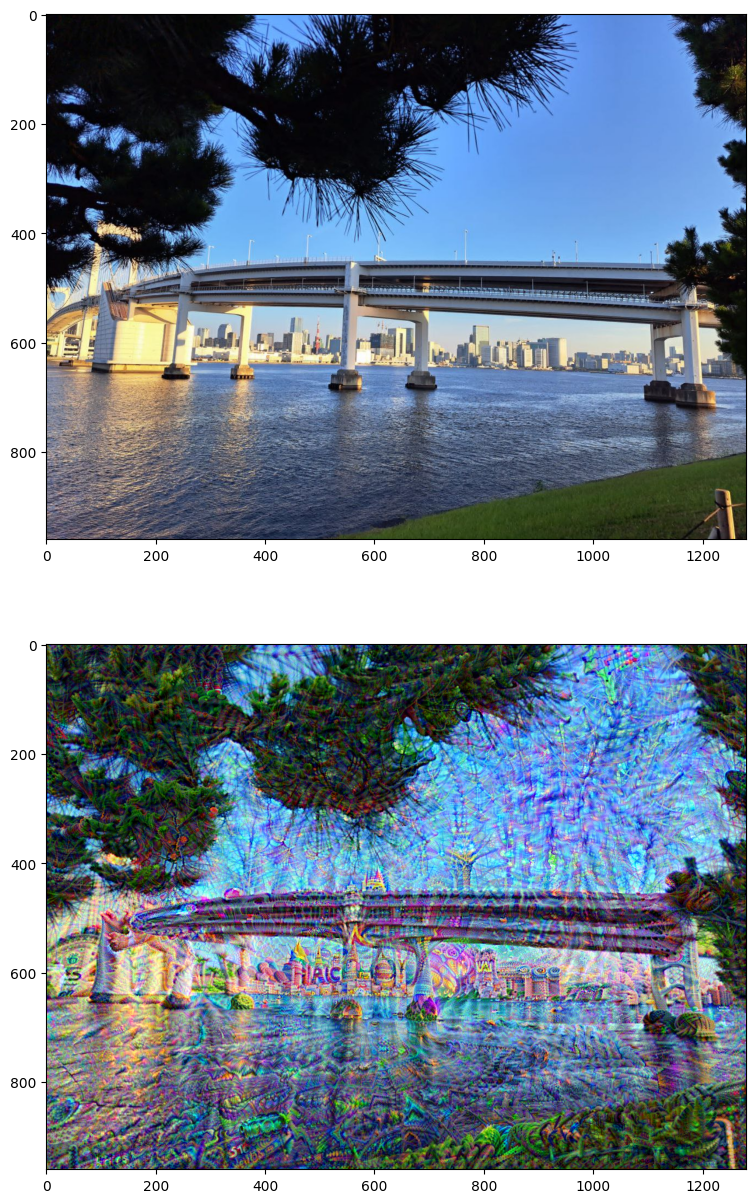

In [13]:
input_img_name = 'photo_rainbow_bridge.jpeg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = None)

print(img.shape, dream_img.shape)

fig, axs = plt.subplots(2,1, figsize = (10, 15))
axs[0].imshow(img)
axs[1].imshow(dream_img)
plt.show()

In [7]:
img = load_

/home/davide/.venvs/deepdream/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


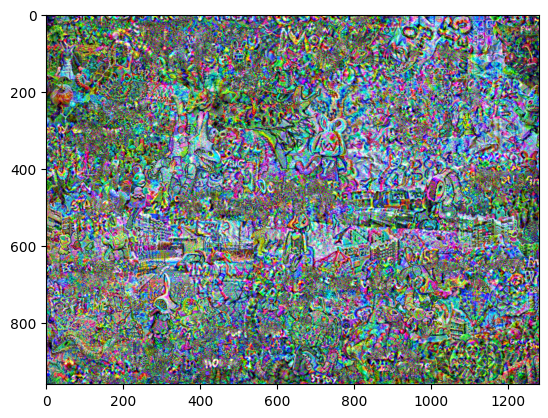

In [8]:
plt.imshow(dream_img)

In [20]:
! nvidia-smi

Thu Aug 24 18:28:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Graphics...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   47C    P0    83W / 300W |  30185MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Graphics...  Off  | 00000000:25:00.0 Off |                    0 |
| N/A   

In [21]:
def model_size_in_MB(model):
    # Get the number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    
    # Assuming each parameter is a float32 (i.e., 4 bytes)
    num_bytes = num_params * 4
    
    # Convert bytes to megabytes
    MB = num_bytes / (1024 * 1024)
    
    return MB

In [27]:
"CLIP_"+open_clip.list_pretrained_tags_by_model("convnext_xxlarge")[0].upper()

'CLIP_LAION2B_S34B_B82K_AUGREG'

In [28]:
model = fetch_and_prepare_model("CONVNEXT_XXLARGE", 'CLIP_LAION2B_S34B_B82K_AUGREG', "cuda")
model_size_in_MB(model)

3217.28466796875

In [29]:
ms = [pw.name for pw in SupportedModels]

combos = []

## That guy models
combos.append(("VGG16", "IMAGENET"))
combos.append(("VGG16_EXPERIMENTAL", "IMAGENET"))
combos.append(("GOOGLENET", "IMAGENET"))
combos.append(("RESNET50", "IMAGENET"))
combos.append(("RESNET50", "PLACES_365"))
combos.append(("ALEXNET", "IMAGENET"))
combos.append(("ALEXNET", "PLACES_365"))

## Only Vision Models - Ours
combos.append(("VIT_B_16", "IMAGENET"))
for p in open_clip.list_pretrained_tags_by_model("ViT-B-16"):
    combos.append(("VIT_B_16", "CLIP_"+p.upper()))
combos.append(("VIT_B_32", "IMAGENET"))
for p in open_clip.list_pretrained_tags_by_model("ViT-B-32"):
    combos.append(("VIT_B_32", "CLIP_"+p.upper()))

combos.append(("VIT_L_16", "IMAGENET"))
combos.append(("VIT_L_32", "IMAGENET"))
for p in open_clip.list_pretrained_tags_by_model("ViT-L-14"):
    combos.append(("VIT_L_14", "CLIP_"+p.upper()))
for p in open_clip.list_pretrained_tags_by_model("ViT-L-14-336"):
    combos.append(("VIT_L_14_336", "CLIP_"+p.upper()))

combos.append(("RN50", "IMAGENET"))
combos.append(("RN50", "PLACES_365"))
combos.append(("RN101", "IMAGENET"))
combos.append(("RN152", "IMAGENET"))

for p in open_clip.list_pretrained_tags_by_model("RN50"):
    combos.append(("RN50", "CLIP_"+p.upper()))
for p in open_clip.list_pretrained_tags_by_model("RN101"):
    combos.append(("RN101", "CLIP_"+p.upper()))

combos.append(("CONVNEXT_BASE", "IMAGENET"))
for p in open_clip.list_pretrained_tags_by_model("convnext_base"):
    combos.append(("CONVNEXT_BASE", "CLIP_"+p.upper()))
for p in open_clip.list_pretrained_tags_by_model("convnext_base_w"):
    combos.append(("CONVNEXT_BASE", "CLIP_"+p.upper()))

for p in open_clip.list_pretrained_tags_by_model("convnext_xxlarge"):
    combos.append(("CONVNEXT_XXLARGE", "CLIP_"+p.upper()))

## OpenCLIP and OpenAI CLIP Models
for m in ms:
    if m.startswith("OPENCLIP"):
        pretraineds = open_clip.list_pretrained_tags_by_model(SupportedModel_to_ModelName[m])
        for p in pretraineds:
            p = "CLIP_"+p.upper()
            combos.append((m, p))
    if m.startswith("CLIP"):
        combos.append((m, "CLIP_OPENAI"))


layers_per_model = {}
layers_per_model["VGG16"] = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
layers_per_model["VGG16_EXPERIMENTAL"] = ['relu3_3', 'relu4_1', 'relu4_2', 'relu4_3', 'relu5_1', 'relu5_2', 'relu5_3', 'mp5']
layers_per_model["GOOGLENET"] = ['inception3b', 'inception4c', 'inception4d', 'inception4e']
layers_per_model["RESNET50"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["ALEXNET"] = ['relu1', 'relu2', 'relu3', 'relu4', 'relu5']
layers_per_model["RN50"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["RN101"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["RN152"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["CONVNEXT_BASE"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["CONVNEXT_XXLARGE"] = ['layer1', 'layer2', 'layer3', 'layer4']
layers_per_model["VIT_B_16"] = ['layer1', 'layer4', 'layer7', 'layer11']
layers_per_model["VIT_B_32"] = ['layer1', 'layer4', 'layer7', 'layer11']
layers_per_model["VIT_L_14"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']
layers_per_model["VIT_L_16"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']
layers_per_model["VIT_L_32"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']
layers_per_model["VIT_L_14_336"] = ['layer1', 'layer5', 'layer9', 'layer13', 'layer17', 'layer21']

for m in ms:
    if m.startswith("CLIP") or m.startswith("OPENCLIP"):
        layers_per_model[m] = ["logits_per_image"]
        

In [31]:
combos

[('VGG16', 'IMAGENET'),
 ('VGG16_EXPERIMENTAL', 'IMAGENET'),
 ('GOOGLENET', 'IMAGENET'),
 ('RESNET50', 'IMAGENET'),
 ('RESNET50', 'PLACES_365'),
 ('ALEXNET', 'IMAGENET'),
 ('ALEXNET', 'PLACES_365'),
 ('VIT_B_16', 'IMAGENET'),
 ('VIT_B_16', 'CLIP_OPENAI'),
 ('VIT_B_16', 'CLIP_LAION400M_E31'),
 ('VIT_B_16', 'CLIP_LAION400M_E32'),
 ('VIT_B_16', 'CLIP_LAION2B_S34B_B88K'),
 ('VIT_B_16', 'CLIP_DATACOMP_L_S1B_B8K'),
 ('VIT_B_16', 'CLIP_COMMONPOOL_L_CLIP_S1B_B8K'),
 ('VIT_B_16', 'CLIP_COMMONPOOL_L_LAION_S1B_B8K'),
 ('VIT_B_16', 'CLIP_COMMONPOOL_L_IMAGE_S1B_B8K'),
 ('VIT_B_16', 'CLIP_COMMONPOOL_L_TEXT_S1B_B8K'),
 ('VIT_B_16', 'CLIP_COMMONPOOL_L_BASIC_S1B_B8K'),
 ('VIT_B_16', 'CLIP_COMMONPOOL_L_S1B_B8K'),
 ('VIT_B_32', 'IMAGENET'),
 ('VIT_B_32', 'CLIP_OPENAI'),
 ('VIT_B_32', 'CLIP_LAION400M_E31'),
 ('VIT_B_32', 'CLIP_LAION400M_E32'),
 ('VIT_B_32', 'CLIP_LAION2B_E16'),
 ('VIT_B_32', 'CLIP_LAION2B_S34B_B79K'),
 ('VIT_B_32', 'CLIP_DATACOMP_M_S128M_B4K'),
 ('VIT_B_32', 'CLIP_COMMONPOOL_M_CLIP_S128M_